# 2.4: Captial Asset Pricing Model (CAPM) and Arbitrage Pricing Theory

### Q2.4.1: Estimate the marlet returns per day (the average of the company returns each day).

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("fsp_case_31_BSD.csv", index_col=0, header=[0, 1])
returns = df["ret"]
R_m = returns.mean(axis=1)
print(R_m)

2017-01-02    0.007347
2017-01-03    0.000909
2017-01-04   -0.002181
2017-01-05    0.002953
2017-01-06    0.000993
                ...   
2018-12-25    0.000000
2018-12-26    0.000936
2018-12-27   -0.017501
2018-12-28    0.017471
2018-12-31    0.005764
Length: 521, dtype: float64


### Q2.4.2: Estimate a rolling beta for each company with a rolling window of 22 days.

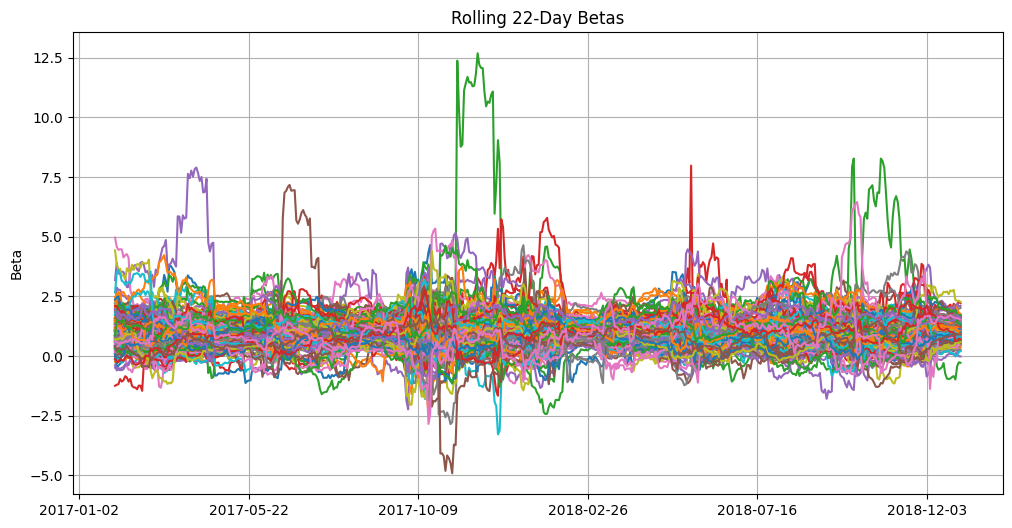

In [12]:
# now we see the correlation of each stock to the average market return (this is beta)

WINDOW = 22

# rolling variance of the market
market_var = R_m.rolling(WINDOW).var()

# container for betas
rolling_betas = pd.DataFrame(index=returns.index, columns=returns.columns)

for company in returns.columns:
    cov_im = returns[company].rolling(WINDOW).cov(R_m)
    rolling_betas[company] = cov_im / market_var

rolling_betas.plot(figsize=(12,6), legend=False)
plt.title("Rolling 22-Day Betas")
plt.ylabel("Beta")
plt.grid(True)
plt.show()



Some companies have fairly stable betas, others are very unstable with massive peaks.

### Q2.4.3: Estimate the cap-weighted market return $R_m$, where for every day

$$
R_m = \text{ret(market)} = \frac{\sum_i \text{mcap}_i \times \text{ret}_i}{\sum_i \text{mcap}_i}
$$

and the weighting coefficient is  $ \sum_i \text{mcap}_i $, how can you interpret this weighting coefficient?


In [15]:


mcaps = df["mcap"]
R_m_cap = (mcaps * returns).sum(axis=1) / mcaps.sum(axis=1)


So far we've been doing just returns (likely percentages), which doen't take into account market capitalisation weighting. If a big company like Apple has a 1% return one day, it should move the overall market returns far more than a smaller company.
Therefore our weighting weights each percentage return proporitional to the fractional market cap the company has.

### Q2.4.4: Re-estimate the rolling beta for each company using the weighted market cap returns.

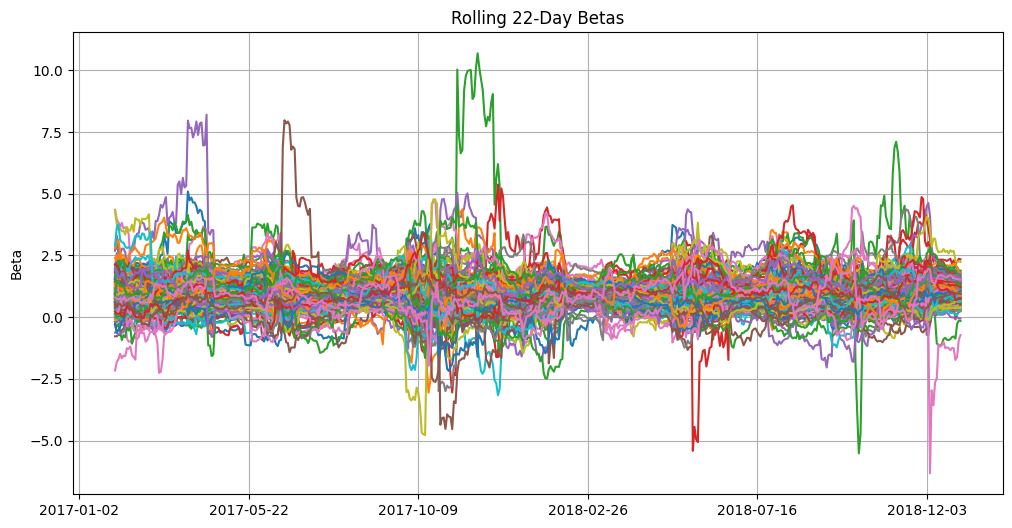

In [17]:
WINDOW = 22

# rolling variance of the market
market_var = R_m_cap.rolling(WINDOW).var()

# container for betas
rolling_betas_cap = pd.DataFrame(index=returns.index, columns=returns.columns)

for company in returns.columns:
    cov_im = returns[company].rolling(WINDOW).cov(R_m_cap)
    rolling_betas_cap[company] = cov_im / market_var

rolling_betas_cap.plot(figsize=(12,6), legend=False)
plt.title("Rolling 22-Day Betas")
plt.ylabel("Beta")
plt.grid(True)
plt.show()


I need to compare these but honestly they basically look the same.

### Q2.4.5: Complete an APT regression on each day of the data (across companies).

#### a. Estimate $a$, $R_m$ and $R_s$.

In [ ]:
# We are perfoming a regression across companies for each day, so a line of best fit for every day.
# We aim to see how each company's return relates to the market return and the company's size factor on that day.

import statsmodels.api as sm
import numpy as np

mcaps_clean = mcaps.copy()
mcaps_clean[mcaps_clean <= 0] = np.nan

print(mcaps_clean)

# Recompute log
size_factor = np.log(mcaps_clean)

# Containers for daily coefficients
a_daily = []
b_m_daily = []
b_s_daily = []
specific_returns = pd.DataFrame(index=returns.index, columns=returns.columns)

# Loop over days
for date in returns.index:
    y = returns.loc[date]
    Rm_day = R_m_cap.loc[date]
    
    X = pd.DataFrame({
        "Rm": [Rm_day] * len(y),
        "Rs": size_factor.loc[date]
    })
    
    # Combine and drop rows with any NaNs
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]
    
    X_clean = sm.add_constant(X_clean, has_constant='add')

    
    if len(y_clean) > 0:  # only run regression if data exists
        model = sm.OLS(y_clean, X_clean).fit()
        a_daily.append(model.params["const"])
        b_m_daily.append(model.params["Rm"])
        b_s_daily.append(model.params["Rs"])

        # Store residuals (specific returns)
        specific_returns.loc[date, y_clean.index] = model.resid
    else:
        a_daily.append(np.nan)
        b_m_daily.append(np.nan)
        b_s_daily.append(np.nan)

# Convert to DataFrame
coef_df = pd.DataFrame({
    "a": a_daily,
    "b_m": b_m_daily,
    "b_s": b_s_daily
}, index=returns.index)

print(coef_df.head())



cmp_id           G_AALLN       G_ABIBB        G_ACFP      G_ADENVX  \
2017-01-02  2.009908e+10  1.805590e+11  1.072477e+10  1.122404e+10   
2017-01-03  1.994554e+10  1.761780e+11  1.081573e+10  1.123631e+10   
2017-01-04  1.970214e+10  1.781740e+11  1.115856e+10  1.161104e+10   
2017-01-05  1.993953e+10  1.813770e+11  1.146524e+10  1.176794e+10   
2017-01-06  1.960623e+10  1.799980e+11  1.140875e+10  1.171886e+10   
...                  ...           ...           ...           ...   
2018-12-25  3.107523e+10  1.129790e+11  1.199039e+10  7.731385e+09   
2018-12-26  3.096529e+10  1.129190e+11  1.198408e+10  7.728651e+09   
2018-12-27  3.042746e+10  1.107270e+11  1.178690e+10  7.517082e+09   
2018-12-28  3.126070e+10  1.113280e+11  1.209209e+10  7.772469e+09   
2018-12-31  3.127341e+10  1.116860e+11  1.231118e+10  7.761036e+09   

cmp_id          G_ADLERR        G_ADNA        G_AFFP        G_AIFP  \
2017-01-02  7.227613e+08  2.713020e+10  1.632362e+09  4.322642e+10   
2017-01-03  7.07842

#### b. Comment on the magnitude and variance of $a$, $R_m$ and $R_s$.

In [28]:
print("Mean coefficients:")
print(coef_df.mean())

print("\nVariance of coefficients:")
print(coef_df.var())

Mean coefficients:
a     -0.004575
b_m    0.000002
b_s    0.000197
dtype: float64

Variance of coefficients:
a      1.741077e-03
b_m    9.941182e-08
b_s    2.987821e-06
dtype: float64


The mean coefficients tell us that 0.46% of returns are not explained by our model, perhaps meaning that these factors are not fully sufficient.
Additionally, it tells us that the market return is very poor at describing the performance of companies.
However, we do see a small correlation between the size of the company and returns, showing that larger firms have very slightly higher returns.

Again for standard deviation, the intercerpt (unexplained) component is largest everyday, showing that these factors are not very descriptive.
The correlation of return standard deviation with both market factor and company size is essentially zero.

#### c. Find the correlation through time for every company between the actual returns and the specific returns.

In [ ]:
temporal_corr = specific_returns.corrwith(returns)
print("Mean temporal correlation across companies:", temporal_corr.mean())
print("Std deviation of temporal correlations:", temporal_corr.std())
print("Min / Max correlation:", temporal_corr.min(), temporal_corr.max())


Mean temporal correlation across companies: 0.8623113446799345
Std deviation of temporal correlations: 0.076474591354882
Min / Max correlation: 0.5397085595769582 0.9844500303220294


The specific returns are the residual returns not explained by the factors in our regression, whereas the actual returns are the full observed (normal) returns of the company.
This regression confirms what we had previously seen, the correlation between this unexplained component and the overall return is extremely high - our original APT model is not explaining the system well.

In [ ]:
#### d. 

In [38]:
Rm_vector = coef_df['b_m'] * R_m_cap
Rs_vector = coef_df['b_s'] * size_factor.mean(axis=1)

R = pd.DataFrame({
    'Rm': Rm_vector,
    'Rs': Rs_vector
}, index=coef_df.index)

WINDOW = 22

# Rolling covariance (2x2) for each 22-day window
rolling_cov = R.rolling(WINDOW).cov()

# To extract covariances
cov_Rm_Rm = rolling_cov.loc[:, 'Rm'].loc[:, 'Rm']  # MultiIndex
cov_Rm_Rs = rolling_cov.loc[:, 'Rm'].loc[:, 'Rs']
cov_Rs_Rs = rolling_cov.loc[:, 'Rs'].loc[:, 'Rs']

# Or, convert to DataFrame aligned by end of window
cov_df = pd.DataFrame({
    'cov_Rm_Rm': cov_Rm_Rm,
    'cov_Rm_Rs': cov_Rm_Rs,
    'cov_Rs_Rs': cov_Rs_Rs
}).dropna()

print(cov_df.describe())


          cov_Rm_Rm     cov_Rm_Rs   cov_Rs_Rs
count  5.000000e+02  5.000000e+02  500.000000
mean   1.671241e-11 -9.418519e-08    0.001630
std    2.866608e-11  1.231133e-07    0.001537
min    7.319419e-14 -5.378084e-07    0.000253
25%    1.392219e-12 -1.215250e-07    0.000827
50%    4.851484e-12 -4.747452e-08    0.001088
75%    1.466565e-11 -2.293572e-08    0.001471
max    1.261674e-10 -2.857086e-09    0.007806


The covariance matrix tells us that the daily market factor variance is very small (and therefore stable).
The size factor variance is quite large, which makes sense since the size of companies likely varies a lot.
The covariance between the two factors is very small, telling us they are essentially unrelated.

#### e. Estimate the covariance matrix of these specific returns. Then perform PCA on the matrix, find the percentage of the variance explained by the first principle component and comment on the result.

In [42]:
from sklearn.decomposition import PCA

cov_E = specific_returns.cov()  # shape: (157 x 157)
print(cov_E.shape)

# Convert covariance matrix to numpy array
cov_matrix = cov_E.values
cov_matrix = cov_E.fillna(0).values

# PCA on covariance matrix
pca = PCA()
pca.fit(cov_matrix)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Percentage of variance explained by the first component
first_pc_var = explained_variance_ratio[0] * 100
print("Variance explained by first principal component: {:.2f}%".format(first_pc_var))


(157, 157)
Variance explained by first principal component: 22.82%
